In [29]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [30]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tf2onnx
import onnx
import yfinance as yfin
import time


In [3]:
# s3_client = boto3.client('s3')
# response = s3_client.get_object(Bucket="gmidha-bigdata-nov07", Key="msftdata.csv")

# status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

# if status == 200:
#     print(f"Successful S3 get_object response. Status - {status}")
#     msft_df = pd.read_csv(response.get("Body"))
#     print(msft_df)
# else:
#     print(f"Unsuccessful S3 get_object response. Status - {status}")

In [4]:
# conn = trino.dbapi.connect(
#         host,
#         port,
#         http_scheme='http',
#         user='admin'
#         )

In [5]:
#msft = pd.read_csv("../msftdata.csv")

In [32]:

yfin.pdr_override()

msft = pdr.get_data_yahoo('MSFT', start='2017-01-01', end='2022-02-01')

print(msft)

/opt/app-root/lib64/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-03   62.790001   62.840000   62.130001   62.580002   57.138737   
2017-01-04   62.480000   62.750000   62.119999   62.299999   56.883064   
2017-01-05   62.189999   62.660000   62.029999   62.299999   56.883064   
2017-01-06   62.299999   63.150002   62.040001   62.840000   57.376122   
2017-01-09   62.759998   63.080002   62.540001   62.639999   57.193516   
...                ...         ...         ...         ...         ...   
2022-01-25  291.519989  294.989990  285.170013  288.489990  283.299896   
2022-01-26  307.989990  308.500000  293.029999  296.709991  291.372009   
2022-01-27  302.660004  307.299988  297.929993  299.839996  294.445740   
2022-01-28  300.230011  308.480011  294.450012  308.260010  302.714264   
2022-01-31  308.950012  312.380005  306.369995  310.980011  305.385315   

              Volume  
Date          

In [33]:

msft.shape

(1279, 6)

In [34]:
msft = msft.reset_index()

In [35]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,62.790001,62.840000,62.130001,62.580002,57.138737,20694100
1,2017-01-04,62.480000,62.750000,62.119999,62.299999,56.883064,21340000
2,2017-01-05,62.189999,62.660000,62.029999,62.299999,56.883064,24876000
3,2017-01-06,62.299999,63.150002,62.040001,62.840000,57.376122,19922900
4,2017-01-09,62.759998,63.080002,62.540001,62.639999,57.193516,20382700


In [36]:
msft.index = pd.to_datetime(msft['Date'], format='%d.%m.%Y %H:%M:%S')

print(msft)

                 Date        Open        High         Low       Close  \
Date                                                                    
2017-01-03 2017-01-03   62.790001   62.840000   62.130001   62.580002   
2017-01-04 2017-01-04   62.480000   62.750000   62.119999   62.299999   
2017-01-05 2017-01-05   62.189999   62.660000   62.029999   62.299999   
2017-01-06 2017-01-06   62.299999   63.150002   62.040001   62.840000   
2017-01-09 2017-01-09   62.759998   63.080002   62.540001   62.639999   
...               ...         ...         ...         ...         ...   
2022-01-25 2022-01-25  291.519989  294.989990  285.170013  288.489990   
2022-01-26 2022-01-26  307.989990  308.500000  293.029999  296.709991   
2022-01-27 2022-01-27  302.660004  307.299988  297.929993  299.839996   
2022-01-28 2022-01-28  300.230011  308.480011  294.450012  308.260010   
2022-01-31 2022-01-31  308.950012  312.380005  306.369995  310.980011   

             Adj Close    Volume  
Date           

In [37]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1279 entries, 2017-01-03 to 2022-01-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1279 non-null   datetime64[ns]
 1   Open       1279 non-null   float64       
 2   High       1279 non-null   float64       
 3   Low        1279 non-null   float64       
 4   Close      1279 non-null   float64       
 5   Adj Close  1279 non-null   float64       
 6   Volume     1279 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 79.9 KB


<Axes: xlabel='Date'>

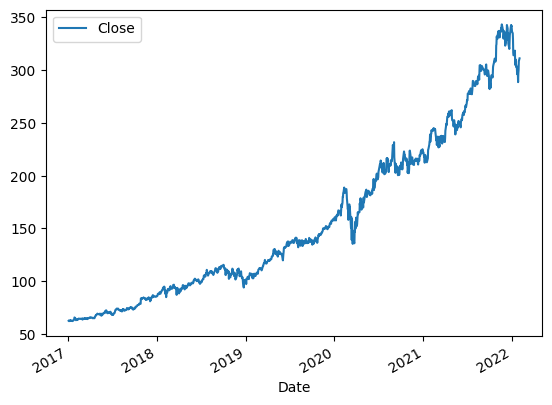

In [38]:
close_data = msft.filter(['Close'])
close_data.plot()

In [39]:
dataset = close_data.values
print(dataset)
training = int(np.ceil(len(dataset) * .95))
print(training)

[[ 62.58000183]
 [ 62.29999924]
 [ 62.29999924]
 ...
 [299.83999634]
 [308.26000977]
 [310.98001099]]
1216


In [40]:

 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:int(training), :]
print(train_data)
# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[[0.00099712]
 [0.        ]
 [0.        ]
 ...
 [0.92899123]
 [0.93319333]
 [0.95908269]]


In [41]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary



<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7f06e93e1490>>

In [42]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
37/37 [==============================] - 3s 29ms/step - loss: 0.0196
Epoch 2/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0062
Epoch 3/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0063
Epoch 4/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0064
Epoch 5/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0052
Epoch 6/10
37/37 [==============================] - 1s 28ms/step - loss: 0.0057
Epoch 7/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0049
Epoch 8/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0052
Epoch 9/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0051
Epoch 10/10
37/37 [==============================] - 1s 27ms/step - loss: 0.0044


In [51]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_test)

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

actual = scaler.inverse_transform(test_data)
print(actual)

print("===")
print(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


[[[0.80894556]
  [0.80492147]
  [0.798191  ]
  ...
  [0.92899123]
  [0.93319333]
  [0.95908269]]

 [[0.80492147]
  [0.798191  ]
  [0.80000721]
  ...
  [0.93319333]
  [0.95908269]
  [0.95107015]]

 [[0.798191  ]
  [0.80000721]
  [0.81019198]
  ...
  [0.95908269]
  [0.95107015]
  [0.96446002]]

 ...

 [[0.95107015]
  [0.96446002]
  [0.96755819]
  ...
  [0.83355296]
  [0.80549127]
  [0.83476373]]

 [[0.96446002]
  [0.96755819]
  [0.97624734]
  ...
  [0.80549127]
  [0.83476373]
  [0.84591008]]

 [[0.96755819]
  [0.97624734]
  [0.9748941 ]
  ...
  [0.83476373]
  [0.84591008]
  [0.87589481]]]
2/2 [==============================] - 0s 9ms/step
[[289.45999146]
 [288.32998657]
 [286.44000244]
 [286.95001221]
 [289.80999756]
 [292.8500061 ]
 [294.6000061 ]
 [293.07998657]
 [290.73001099]
 [296.76998901]
 [304.35998535]
 [304.6499939 ]
 [302.61999512]
 [302.01000977]
 [299.08999634]
 [299.72000122]
 [303.58999634]
 [301.88000488]
 [301.82998657]
 [301.1499939 ]
 [301.14001465]
 [300.17999268]
 [3

/tmp/ipykernel_510/3634165671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


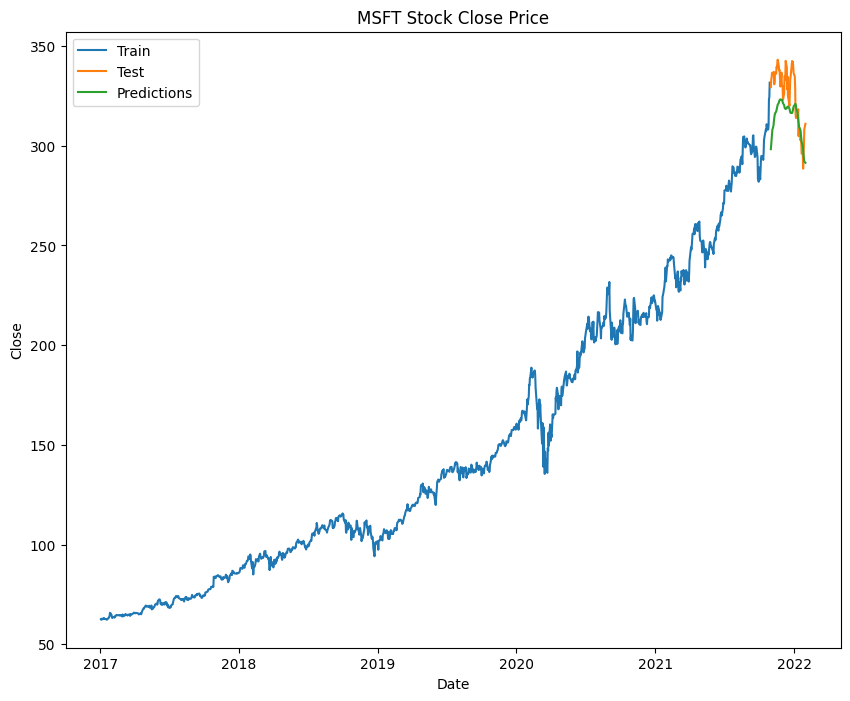

In [45]:
train = msft[:training]
test = msft[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('MSFT Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

In [52]:
model.save("./stock_predict.keras")

In [55]:
onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, "./model.onnx")

2024-02-13 09:34:51.930617: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-13 09:34:51.930752: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-13 09:34:52.034579: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-13 09:34:52.034697: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-13 09:34:52.119600: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
